## Importar módulos

In [122]:
import os
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import pandas_ta as ta
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-dark')
import warnings
warnings.filterwarnings("ignore")

## Importar funciones de backtest

In [136]:
%run ../functions/backtest_functions.ipynb
%run ../functions/trading_functions.ipynb

## Descarga de datos

In [124]:
# Descarga de los precios de BTC/USD
df_highest_file_path = '../csv/df_highest_timeframe.csv'
df_lowest_file_path = '../csv/df_lowest_timeframe.csv'
if os.path.exists(df_highest_file_path) and os.path.exists(df_lowest_file_path):
    # Establecer tipo de datos
    data_types = {
        'date': 'str',
        'open': 'float',
        'high': 'float',
        'low': 'float',
        'close': 'float',
        'volume': 'float'
    }
    df = pd.read_csv(df_highest_file_path, dtype=data_types)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df_lowest_timeframe = pd.read_csv(df_lowest_file_path, dtype=data_types)
    df_lowest_timeframe['date'] = pd.to_datetime(df_lowest_timeframe['date'])
    df_lowest_timeframe = df_lowest_timeframe.set_index('date')
    print("Archivo cargado exitosamente.")
    # Puedes realizar operaciones adicionales con el DataFrame aquí
else:
    print("El archivo no existe en la ubicación especificada. Descargando ....")
    # Descarga de históricos OHLCV
    start_date = pd.Timestamp('2014-01-01').timestamp()
    end_date = pd.Timestamp.now(tz='UTC').timestamp()
    df = fetch_bitstamp_data('btcusd', start=start_date, end=end_date, timeframe=3600)
    df_lowest_timeframe = fetch_bitstamp_data('btcusd', start=start_date, end=end_date, timeframe=60)
    # Almacenar en CSV
    df.to_csv('df_highest_timeframe.csv', index=True)
    df_lowest_timeframe.to_csv('df_lowest_timeframe.csv', index=True)

Archivo cargado exitosamente.


In [125]:
# Descarga de precios del índice de referencia (DAX30)
df_index_path = '../csv/df_index.csv'
if os.path.exists(df_index_path):
    # El archivo existe, cargarlo en un DataFrame
    df_index = pd.read_csv(df_index_path, sep='\t')
    df_index.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'vol_rm', 'spread_rm']
    df_index = df_index.astype({col: dtype for col, dtype in data_types.items()})
    df_index = df_index.drop(labels=['vol_rm', 'spread_rm'], axis=1)
    df_index['date'] = pd.to_datetime(df_index['date'])
    df_index = df_index.set_index('date')
    print("Archivo cargado exitosamente.")
else:
    if mt5.initialize():
        # Obtener índice de referencia
        data_index = mt5.copy_rates_range('GDAXI', mt5.TIMEFRAME_D1, df.index[0], df.index[-1])
        df_index = pd.DataFrame(data_index['close'], index=data_index['time'], columns=['index'])
        df_index = np.log(df_index).diff().dropna()
        df_index.index.names = ['date']
        df_index.index = pd.to_datetime(df_index.index, unit='s')
        df_index = df_index.loc[df.index[0]:df.index[-1]]

Archivo cargado exitosamente.


## Ingeniería de características

In [126]:
### Sistema Alpha (por Jose Antonio Fernández Martín) ###
def alpha_system(df):
    #ichimoku solo las líneas superior e inferior de la nube. Params (7, 22, 44) ó (120, 26, 52)
    ichimoku = df.ta.ichimoku(high='high', low='low', close='close', tenkan=120, kijun=26, senkou=52)
    stochastic = df.ta.stoch(high='high', low='low', close='close', k=78, d=78, mamode='ema', offset=1)
    vortex = df.ta.vortex(high='high', low='low', close='close', length=24)
    df['ichimoku_a'] = ichimoku[0]['ISA_120']
    df['ichimoku_b'] = ichimoku[0]['ISB_26']
    df['stoch_k'] = stochastic['STOCHk_78_78_3']
    df['stoch_d'] = stochastic['STOCHd_78_78_3']
    df['vortex_pos'] = vortex['VTXP_24']
    df['vortex_neg'] = vortex['VTXM_24']
    # Eliminar filas con NaN
    df = df.dropna(axis=0)
    # Condición de compra
    df['vortex_buy_signal'] = (df['vortex_pos'] > df['vortex_neg'])
    df['stoch_buy_signal'] = (df['stoch_k'] > df['stoch_d'])
    df['ichimoku_buy_signal'] = (df['close'] > df['ichimoku_a']) & (df['close'] > df['ichimoku_b'])
    # Condición de venta
    df['vortex_sell_signal'] = (df['vortex_pos'] < df['vortex_neg'])
    df['stoch_sell_signal'] = (df['stoch_k'] < df['stoch_d'])
    df['ichimoku_sell_signal'] = (df['close'] < df['ichimoku_a']) & (df['close'] < df['ichimoku_b'])
    # Establecer señal
    df['buy_signal'] = df[['vortex_buy_signal', 'stoch_buy_signal', 'ichimoku_buy_signal']].all(axis=1)
    df['sell_signal'] = df[['vortex_sell_signal', 'stoch_sell_signal', 'ichimoku_sell_signal']].all(axis=1)
    # Asignar 1 donde las condiciones de compra se cumplen por primera vez
    df['signal'] = np.where(df['buy_signal'], 1, 0)
    # Asignar -1 donde las condiciones de venta se cumplen por primera vez
    df['signal'] = np.where(df['sell_signal'], -1, df['signal'])
    # Eliminar señales repetidas manteniendo la primera ocurrencia de cada señal
    df['signal'] = df['signal'].replace(0, np.nan)
    changes = df['signal'].diff().ne(0)
    df['signal'] = df['signal'].where(changes).fillna(0).astype('int64')
    # Eliminar columnas innecesarias
    df = df.drop(labels=['vortex_buy_signal', 'stoch_buy_signal', 'ichimoku_buy_signal', 
                    'vortex_sell_signal', 'stoch_sell_signal', 'ichimoku_sell_signal', 'buy_signal', 'sell_signal'], axis=1)
    # return dataframe
    return df

In [127]:
# Agregar señales de trading al dataframe
df = alpha_system(df)
# Agregar cálculo de stop loss y take profit
stdev = df['close'].pct_change().std()
df = run_tp_sl(df, df_lowest_timeframe, tp=stdev*3.0, sl=-stdev*1.5)

## Análisis exploratorio de datos

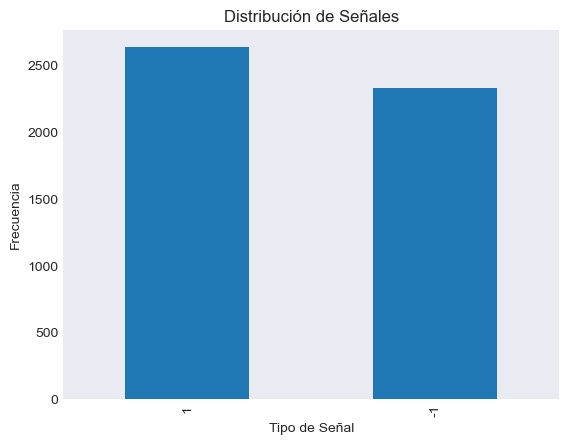

In [131]:
# Visualizar distribución de señales de trading
df['signal'][(df['signal']==1) | (df['signal']==-1)].value_counts().plot(kind='bar')
plt.title('Distribución de Señales')
plt.xlabel('Tipo de Señal')
plt.ylabel('Frecuencia')
plt.show()

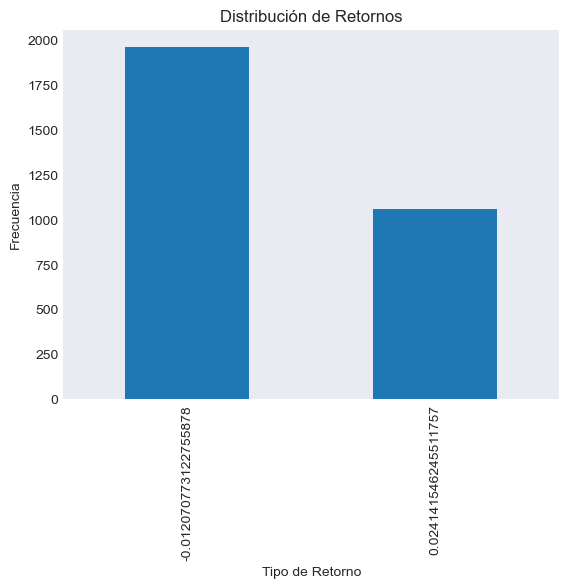

In [132]:
# Visualizar distribución de rendimientos
df['returns'][df['returns']!=0].value_counts().plot(kind='bar')
plt.title('Distribución de Retornos')
plt.xlabel('Tipo de Retorno')
plt.ylabel('Frecuencia')
plt.show()

## Evaluación de resultados


    __________________________________________________
    Portfolio: 
	alpha_strategy: 100.00%
    __________________________________________________
    Beta: 0.001
    Alpha: 0.005
    Sharpe: 0.106
    Sortino: 190157561546951.22
    ___________________________________________________
    VaR: -9.083
    cVaR: -11.527
    ___________________________________________________
    


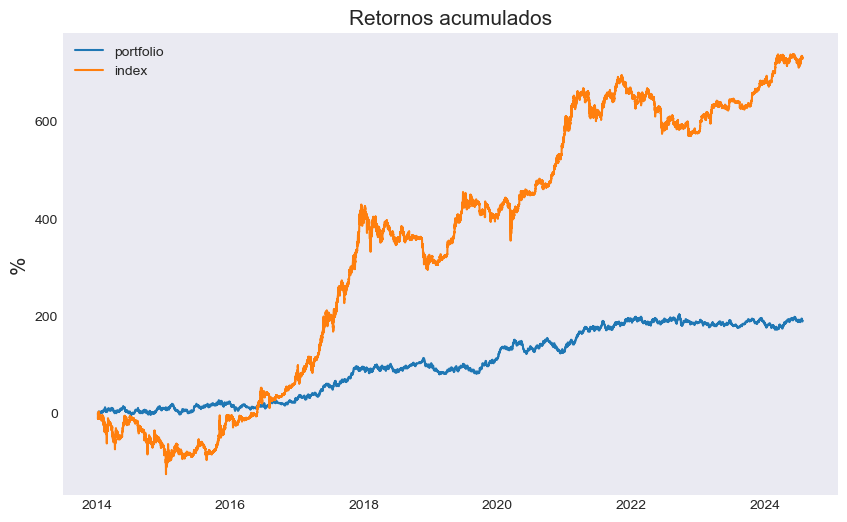

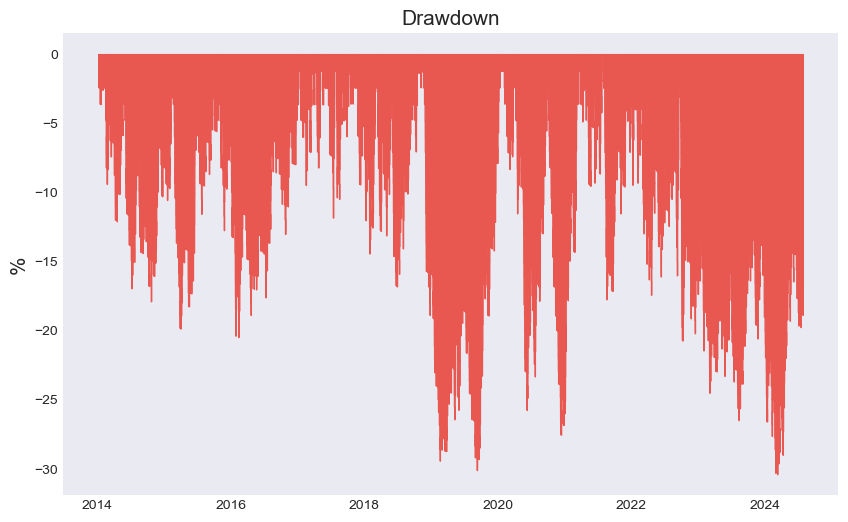

In [134]:
# Backtest de la estrategia
weights = pd.DataFrame([1.], columns=['weights'], index=['alpha_strategy'])
portfolio = df[['returns']].rename(columns={'returns': 'alpha_strategy'})
benchmark = df[['close']].pct_change().dropna().rename(columns={'close':'index'})
static_backtest_function(weights=weights, portfolio=portfolio, benchmark=benchmark, timeframe=365)

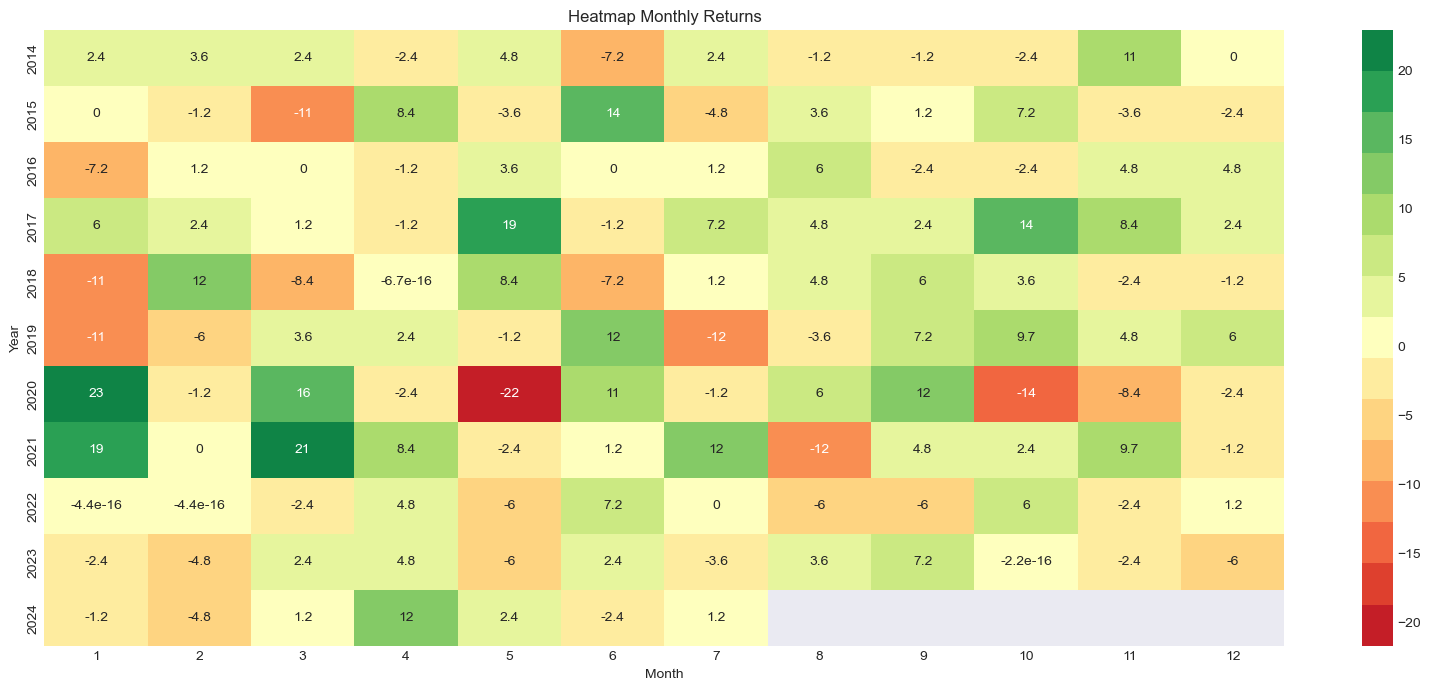

In [137]:
# Monthly returns visualization
profitable_month_return(df['returns'])

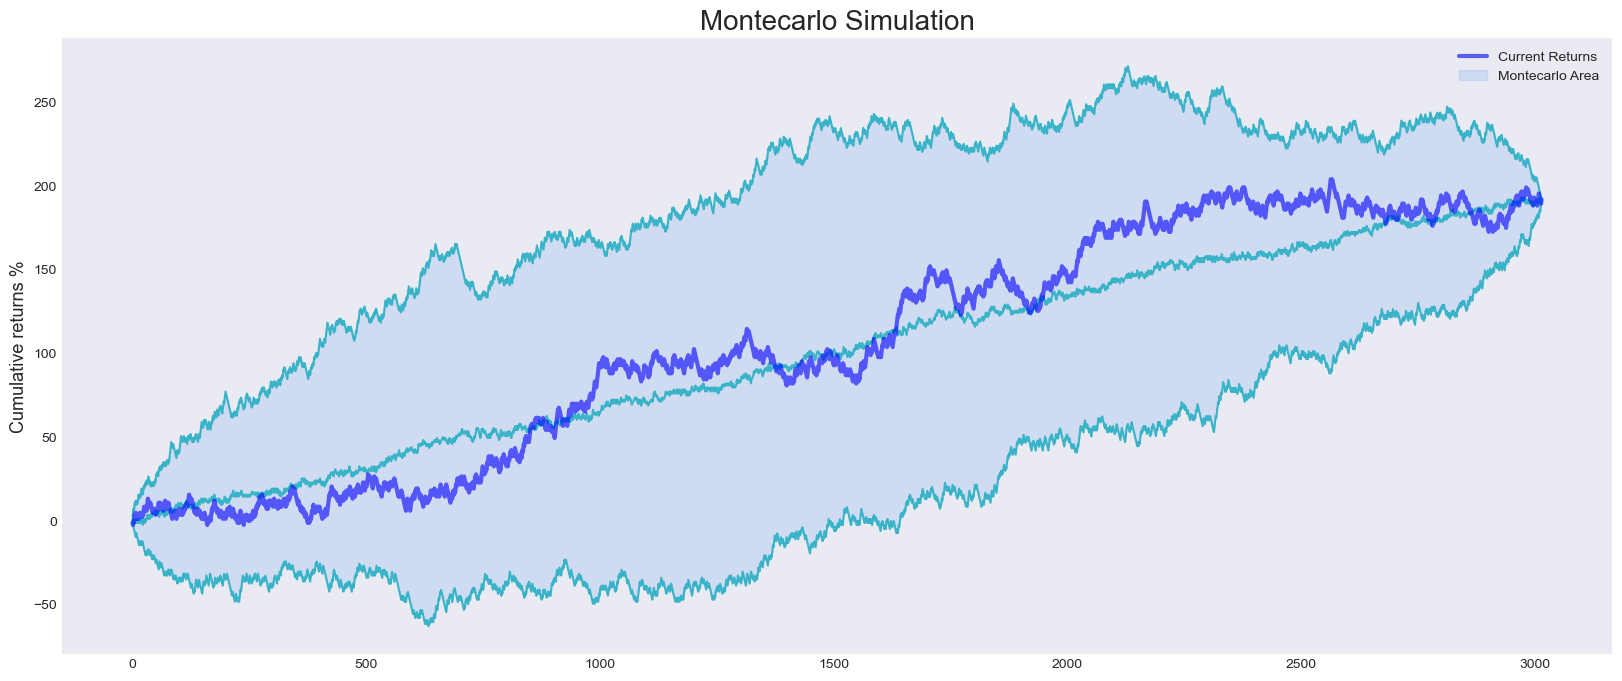

In [141]:
# Simple Montecarlo simulation visualization
montecarlo_simulation(df['returns'], method='simple')

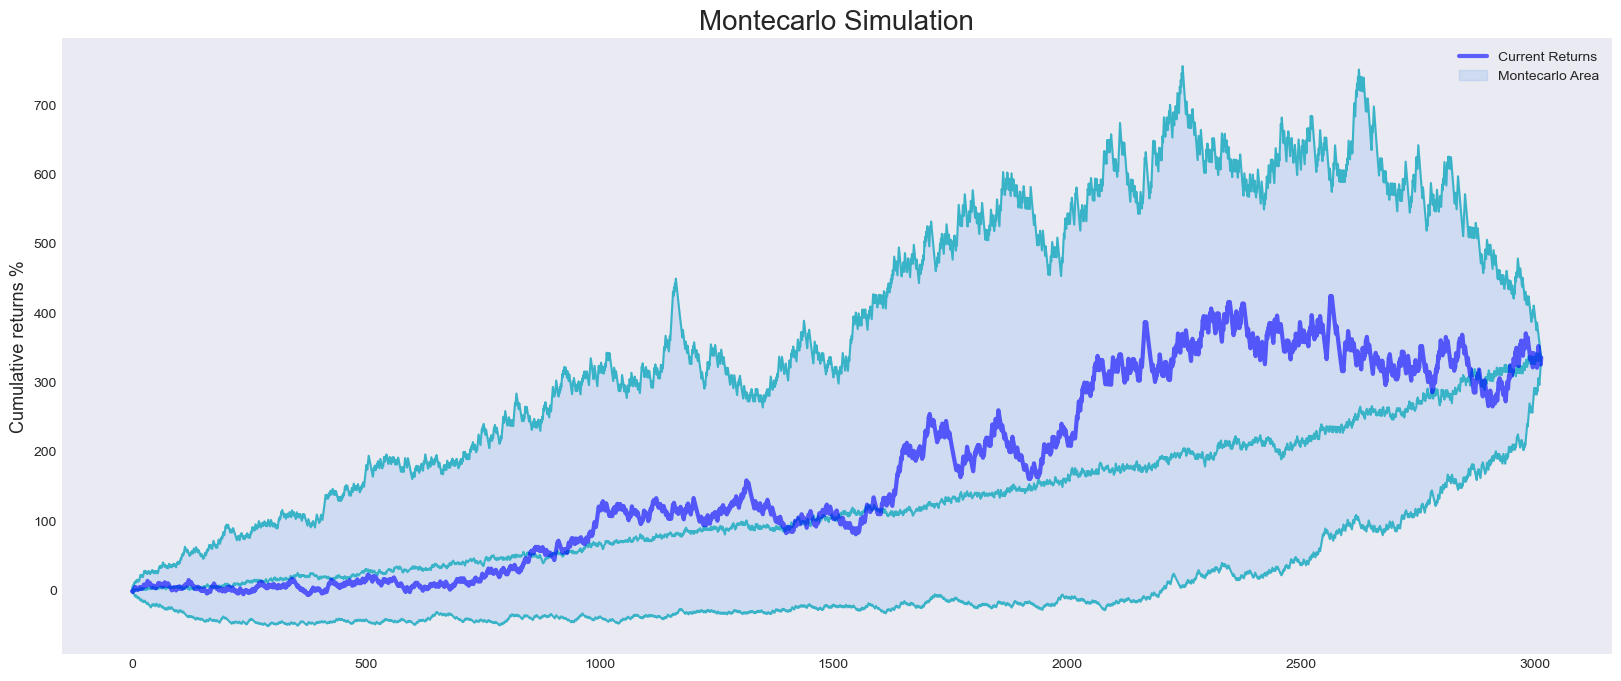

In [139]:
# Compounded Montecarlo simulation visualization
montecarlo_simulation(df['returns'])